In [1]:
#Connect Google Drive to colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Connecting kaggle so dataset can be downloaded
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
#Downloading the Dataset
! kaggle datasets download hojjatk/mnist-dataset

Dataset URL: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
License(s): copyright-authors
 50% 11.0M/22.0M [00:00<00:00, 114MB/s]
100% 22.0M/22.0M [00:00<00:00, 142MB/s]


In [4]:
#Unpackaging the dataset folder
!unzip mnist-dataset.zip

Archive:  mnist-dataset.zip
  inflating: t10k-images-idx3-ubyte/t10k-images-idx3-ubyte  
  inflating: t10k-images.idx3-ubyte  
  inflating: t10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte  
  inflating: t10k-labels.idx1-ubyte  
  inflating: train-images-idx3-ubyte/train-images-idx3-ubyte  
  inflating: train-images.idx3-ubyte  
  inflating: train-labels-idx1-ubyte/train-labels-idx1-ubyte  
  inflating: train-labels.idx1-ubyte  


In [5]:
#Function unpackages a pickle folder
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [6]:
#Converts a Ubyte file to a list
def read_ubyte_file_to_list(filename):
  """Reads a ubyte file and returns its content as a list of integers.

  Args:
    filename: The path to the ubyte file.

  Returns:
    A list of integers representing the content of the ubyte file.
  """
  with open(filename, 'rb') as f:
    data = f.read()
    data_list = list(data)
  return data_list

In [7]:
import pickle
import numpy as np
import pandas as pd

#Put train data and labels into numpy array and store them in a pickle file
train_data = []
trian_labels = []
train_data = read_ubyte_file_to_list('train-images.idx3-ubyte')[16:]
train_labels = read_ubyte_file_to_list('train-labels.idx1-ubyte')[8:]
for i in range(0, len(train_data)):
  train_data[i] = train_data[i]/255. #Converts each pixel into a number between 0 and 1
tr_mean = np.mean(train_data) #Taking the mean of the train data
tr_std = np.std(train_data) #Taking the standard deviation of train data
train_data = [(x - tr_mean)/tr_std for x in train_data] #normalizing the train data
train_data = np.array(train_data) #storing data into a numpy array
train_data = train_data.reshape(60000,784) #Reshaping the data into image dimensions
train_labels = np.array(train_labels) #storing the labels in a numpy array
dict_data_train = {'data': train_data, 'labels': train_labels} #storing the images and labels in a dictionary
pickle.dump(dict_data_train,open('mnist_train_data','wb')) #converting dictionary to a pickle file

#Put test data and labels into numpy array and store them in a pickle file
#All steps are the same from preparing the train dataset
test_data = []
test_labels = []
test_data = read_ubyte_file_to_list('t10k-images.idx3-ubyte')[16:]
test_labels = read_ubyte_file_to_list('t10k-labels.idx1-ubyte')[8:]
for i in range(0, len(test_data)):
  test_data[i] = test_data[i]/255.0
test_data = [(x - tr_mean)/tr_std for x in test_data] #Use the train mean and standard deviation because the test mean and standard deviation are unknown
test_data = np.array(test_data)
test_data = test_data.reshape(10000,784)
test_labels = np.array(test_labels)
dict_data_test = {'data': test_data, 'labels': test_labels}
pickle.dump(dict_data_test,open('mnist_test_data','wb'))

In [8]:
#Creating custom dataset
import torch.nn.functional as F
import torch
import torchvision
from torch.utils.data import Dataset, DataLoader, Sampler
class MyMNIST(Dataset):
  def __init__(self,filename):
    dict_data = unpickle(filename)
    self.x = dict_data['data']
    self.y = dict_data['labels']
    self.x = torch.tensor(self.x,dtype=torch.float32)
    self.y = torch.tensor(self.y,dtype=torch.long)


  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]


In [9]:
#Importing train and test data into custom dataset.
train_dataset = MyMNIST('mnist_train_data')
test_dataset = MyMNIST('mnist_test_data')

In [10]:
#Importing datasets into dataloader
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=10, shuffle=True)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([10, 784])
Shape of y: torch.Size([10]) torch.int64


In [11]:
#building the training model
import torch
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.layers(x)

model = MLP().to(device)
print(model)

Using cpu device
MLP(
  (layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=10, bias=True)
  )
)


In [12]:
#Defining loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

In [13]:
def train(data_loader, model, criterion, optimizer):
  model.train()
  num_batches = len(data_loader)
  num_items = len(data_loader.dataset)
  total_loss = 0
  total_correct = 0
  for data, target in data_loader:
    #Copy data and tragets to GPU
    data, target = data.to(device), target.to(device)

    #Do a forward pass
    output = model(data)

    #Calculate Loss
    loss = criterion(output, target)
    total_loss += loss

    #Count number of correct digits
    total_correct += (torch.argmax(output, dim=1) == target).sum().item()

    #Backpropagation
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
  #Printing the average loss and accuarcy for train data
  train_loss = total_loss / num_batches
  train_accuracy = total_correct / num_items
  train_losses.append(train_loss.item())
  print(f"Train average loss: {train_loss:7f}, train accuracy: {train_accuracy:.2%}")
  #Printing the average loss and accuuracy for test data
  num_batches_test = len(test_dataloader)
  num_items_test = len(test_dataloader.dataset)
  total_loss_test = 0
  total_correct_test = 0
  for data, target in test_dataloader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    loss = criterion(output, target)
    total_loss_test += loss
    total_correct_test += (torch.argmax(output, dim=1) == target).sum().item()
  test_loss = total_loss_test / num_batches_test
  test_accuracy = total_correct_test / num_items_test
  test_losses.append(test_loss.item())
  print(f"Test Average loss: {test_loss:7f}, test accuracy: {test_accuracy:.2%}")



Training epoch 1
-------------------------------
Train average loss: 0.031163, train accuracy: 98.97%
Test Average loss: 0.086724, test accuracy: 97.60%
Training epoch 2
-------------------------------
Train average loss: 0.029645, train accuracy: 99.01%
Test Average loss: 0.086739, test accuracy: 97.64%
Training epoch 3
-------------------------------
Train average loss: 0.024690, train accuracy: 99.13%
Test Average loss: 0.100781, test accuracy: 97.38%
Training epoch 4
-------------------------------
Train average loss: 0.021069, train accuracy: 99.30%
Test Average loss: 0.100313, test accuracy: 97.70%
Training epoch 5
-------------------------------
Train average loss: 0.020318, train accuracy: 99.30%
Test Average loss: 0.093318, test accuracy: 97.85%
Training epoch 6
-------------------------------
Train average loss: 0.016201, train accuracy: 99.48%
Test Average loss: 0.096405, test accuracy: 97.94%
Training epoch 7
-------------------------------
Train average loss: 0.019613, tra

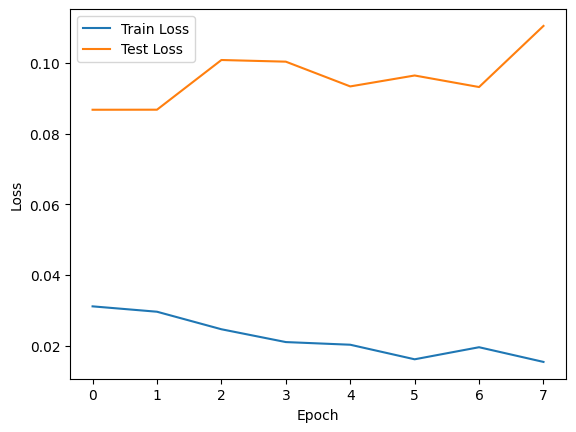

CPU times: user 48.1 s, sys: 221 ms, total: 48.4 s
Wall time: 50.4 s


In [16]:
#Training the model
%%time
import matplotlib.pyplot as plt
epochs = 8
test_losses =[]
train_losses=[]
for epoch in range(epochs):
  print(f"Training epoch {epoch+1}\n-------------------------------")
  train(train_dataloader, model, criterion, optimizer)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Train accuracy = 99.5%, test accuracy = 97.62%

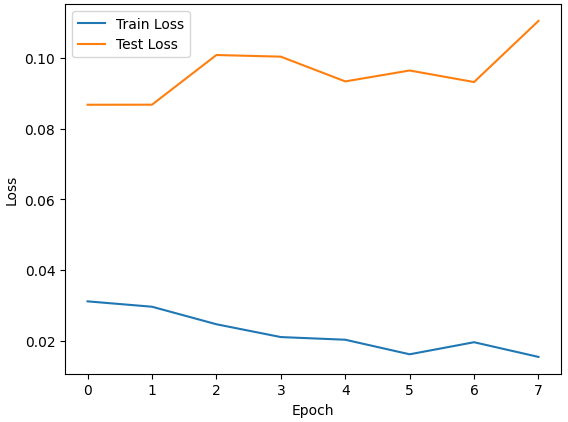